In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
l = 1000 # 1000 time steps
t = np.linspace(0, 100, l) # a time interval of 100 seconds
a = np.zeros(1000) # initialize accelaration
v = np.zeros(1000) # initialize velocity
s = np.zeros(1000) # initialize position
variance_Zs = 1  # variance of system error with respect to position
variance_Zv = 0.01  # variance of system error with respect to velocity
variance_Za = 0.0001 # variance of system error with respect to acceleration
variance_Ms = 100 # /sigma_Ms^2 = 20 # variance of measurement error with respect to position
variance_Mv = 10 # /sigma_Ms^2 = 2 # variance of measurement error with respect to velocity
variance_Ma = 1 # /sigma_Ma^2 =0.2 # variance of measurement error with respect to acceleration
noise_Zs = np.random.normal(0,variance_Zs,1000)
noise_Zv = np.random.normal(0,variance_Zv,1000) 
noise_Za = np.random.normal(0,variance_Za,1000) 
noise_Ms = np.random.normal(0,variance_Ms,1000)  
noise_Mv = np.random.normal(0,variance_Mv,1000)
noise_Ma = np.random.normal(0,variance_Ma,1000)
Ts = 100/l
Ad = np.matrix([[1,Ts,0.5*(Ts*Ts)],
                  [0,1,Ts],
                  [0,0,0]]) ## not sure if it should be 0,0,1 (from textbook) or 0,0,0 (from my derivation)
Bd = np.array ([0.5*(Ts*Ts),Ts,1]).reshape(-1,1)
u = np.zeros((1,1000))
u[:,200:225] = -10 # step function
G = np.matrix ([[1,0,0],[0,1,0],[0,0,1]])
Gd = Ad
Md = Gd
z = np.vstack((noise_Zs,noise_Zv,noise_Za))
w = np.vstack((noise_Ms,noise_Mv,noise_Ma))
StateMatrix = np.zeros((3,1000))
MeasurementMatrix = np.zeros((3,1000))
v[0] = 50
x = np.array ([[s[0]],[v[0]],[a[0]]])
y = np.array ([0,0,1])
z_0 = z[:,0].reshape (3,1)
w_0 = w[:,0].reshape (3,1)
C = np.matrix ([[1,0,0],[0,1,0],[0,0,1]])
D = np.array ([0,0,1]).reshape(-1,1)
StateMatrix[:,0] = np.squeeze(x)
MeasurementMatrix[:,0] = np.squeeze(y)
for k in range(0, len(t)):
      z_k = z[:,k].reshape (3,1)
      w_k = w[:,k].reshape (3,1)
      u_k = u[:,k].reshape (1,1)
      x = Ad * x + Bd * u_k + Gd * z_k
      y = C * x + Md * w_k
      StateMatrix[:,k] = np.squeeze(x)
      MeasurementMatrix[:,k] = np.squeeze(y)

In [15]:
Q = np.diag([variance_Zs, variance_Zv, variance_Za]) 

R = np.diag([variance_Ms, variance_Mv, variance_Ma])


In [22]:
# Kalman filter implementation with RTS smoothing #version 0.2
StateEstimate = np.zeros((3, len(t)))
SmoothedEstimate = np.zeros((3, len(t)))
x_hat = np.zeros((3, 1))
P = np.diag([1000, 1000, 1000])
StateEstimate[:, 0] = np.squeeze(x_hat)
SmoothedEstimate[:, -1] = np.squeeze(x_hat)

Ad = np.matrix([[1,Ts,0.5*(Ts*Ts)],
                  [0,1,Ts],
                  [0,0,1]]) 

for k in range(0, len(t)):
    # Prediction step

    x_hat_minus = Ad.dot(x_hat) 
    P_minus = Ad.dot(P).dot(Ad.T) + Gd.dot(Q).dot(Gd.T)

    # Update step
    y = MeasurementMatrix[:, k].reshape(-1, 1)
    S = C.dot(P_minus).dot(C.T) + Md.dot(R).dot(Md.T)
    K = P_minus.dot(C.T).dot(np.linalg.pinv(S))
    x_hat = x_hat_minus + K.dot(y - C.dot(x_hat_minus))
    P = (np.eye(3) - K.dot(C)).dot(P_minus)

    # Save the estimated state
    StateEstimate[:, k] = np.squeeze(x_hat)

# # RTS smoothing
#     if k > 0:
#         J = P.dot(Ad.T).dot(np.linalg.pinv(P_minus))
#         x_hat_smooth = x_hat + J.dot(SmoothedEstimate[:, k].reshape(-1, 1) - x_hat_minus)
#         P_smooth = P + J.dot(P_smooth - P_minus).dot(J.T)
#         SmoothedEstimate[:, -k - 1] = np.squeeze(x_hat_smooth)

     # RTS smoothing
    SmoothedEstimate[:, -1] = np.squeeze(x_hat)
    P_smooth = P
    for j in range(len(t)-2, k-1, -1):
        x_hat_smooth = SmoothedEstimate[:, j+1].reshape(-1, 1)
        x_hat_minus_smooth = Ad.dot(x_hat_smooth)
        P_minus_smooth = Ad.dot(P_smooth).dot(Ad.T) + Gd.dot(Q).dot(Gd.T)
        J = P_smooth.dot(Ad.T).dot(np.linalg.pinv(P_minus_smooth))
        x_hat_smooth = x_hat_smooth + J.dot(x_hat - x_hat_minus_smooth)
        P_smooth = P + J.dot(P_smooth - P_minus_smooth).dot(J.T)
        SmoothedEstimate[:, j] = np.squeeze(x_hat_smooth)

# SmoothedEstimate[:, 0] = np.squeeze(x_hat)


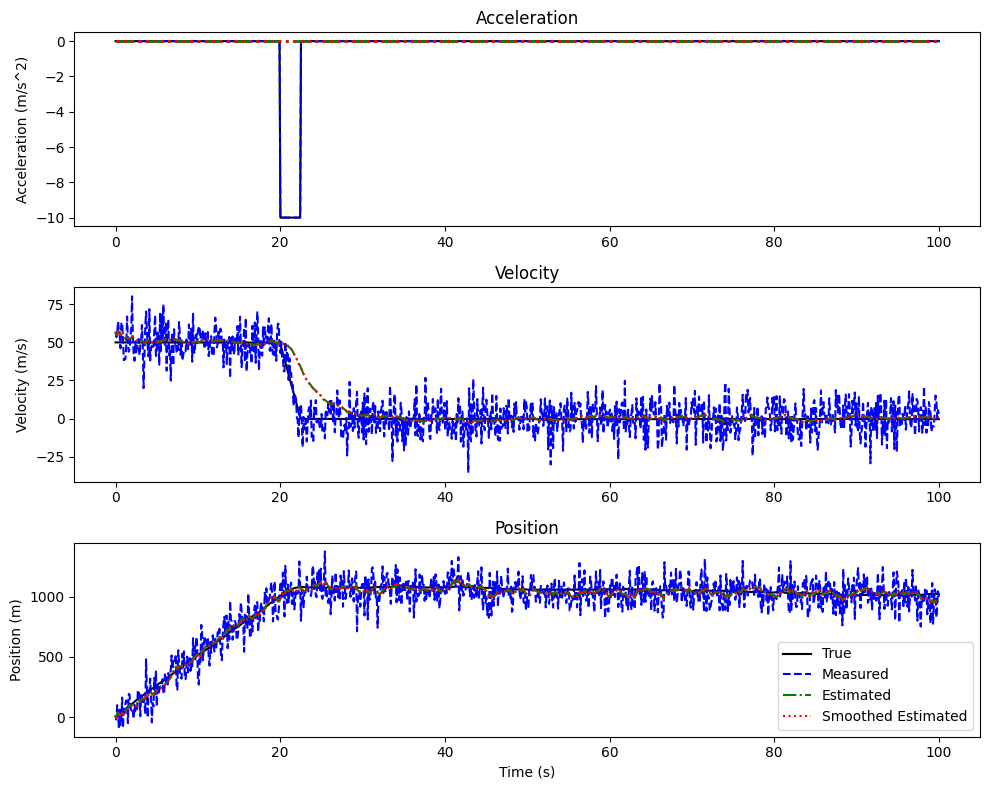

In [23]:
import matplotlib.pyplot as plt

# Plot results
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,8))

# Plot acceleration
ax[0].plot(t, StateMatrix[2,:], 'k-', label='True')
ax[0].plot(t, MeasurementMatrix[2,:], 'b--', label='Measured')
ax[0].plot(t, StateEstimate[2,:], 'g-.', label='Estimated', linewidth=2)
ax[0].plot(t, SmoothedEstimate[2,:], 'r:', label='Smoothed Estimated',linewidth=2)
ax[0].set_ylabel('Acceleration (m/s^2)')
ax[0].set_title('Acceleration')

# Plot velocity
ax[1].plot(t, StateMatrix[1,:], 'k-', label='True')
ax[1].plot(t, MeasurementMatrix[1,:], 'b--', label='Measured')
ax[1].plot(t, StateEstimate[1,:], 'g-.', label='Estimated')
ax[1].plot(t, SmoothedEstimate[1,:], 'r:', label='Smoothed Estimated')
ax[1].set_ylabel('Velocity (m/s)')
ax[1].set_title('Velocity')

# Plot position
ax[2].plot(t, StateMatrix[0,:], 'k-', label='True')
ax[2].plot(t, MeasurementMatrix[0,:], 'b--', label='Measured')
ax[2].plot(t, StateEstimate[0,:], 'g-.', label='Estimated')
ax[2].plot(t, SmoothedEstimate[0,:], 'r:', label='Smoothed Estimated')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Position (m)')
ax[2].set_title('Position')

plt.tight_layout()
plt.legend()
plt.show()
